# Imports

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

# Define the simulation parameters

In [34]:
# Simulation Parameters

nx  = 500 * 2
box = 50 * 2
dx = box / nx
dt_courant = dx
dt = 0.99 * dt_courant
tmax = 200
ppc = 50

# Plasma Parameters

omega_p = 1
vth = 0.1

electrons = zpic.Species( "electrons", m_q=-1, ppc=ppc, uth=[ vth, vth, vth ] )
sim = zpic.Simulation( nx=nx, box=box, dt=dt, species=[electrons] ) 
B0 = 0

t = np.array( [ sim.t ] )
Ex = np.array( [ sim.emf.Ex.copy() ] )
Ey = np.array( [ sim.emf.Ey.copy() ] )
Ez = np.array( [ sim.emf.Ez.copy() ] )

while sim.t < tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    sim.iter()
    t = np.append( t, sim.t )
    Ex = np.append( Ex, [ sim.emf.Ex.copy() ], axis=0 )
    Ey = np.append( Ey, [ sim.emf.Ey.copy() ], axis=0 )
    Ez = np.append( Ez, [ sim.emf.Ez.copy() ], axis=0 )


# Plot the FFT of Ex and check the dispersion relation

Maximum wave vector    > 31.353094682826136
Wave vector resolution > 0.06283185307179551
Maximum frequency      > 31.70187113594592
Frequency resolution   > 0.03138799122370983


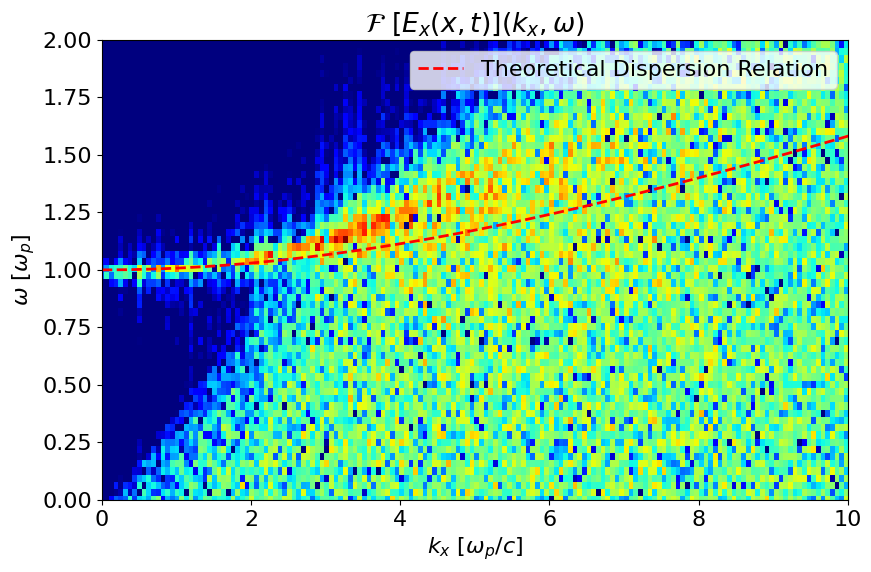

In [35]:
k = np.fft.fftshift(np.fft.fftfreq(nx, d=dx)) * 2 * np.pi
w = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt)) * 2 * np.pi
print("Maximum wave vector    >", k[-1])
print("Wave vector resolution >", k[1] - k[0])
print("Maximum frequency      >", w[-1])
print("Frequency resolution   >", w[1] - w[0])

Ex_fft = np.fft.fftshift(np.fft.fft2(Ex))

plt.figure(figsize=(9, 6))
plt.title("Electrostatic Electron Plasma Wave Propagation")

plt.imshow(np.abs(Ex_fft) / np.max(np.abs(Ex_fft)),
           aspect='auto',
           extent=[k[0], k[-1], w[0], w[-1]],
           cmap='jet',
           norm=mpl.colors.LogNorm(1e-2),
           interpolation='none',
           origin='lower')

plt.plot(k, np.sqrt(1.0 + (1.5*k**2*vth**2)/omega_p**2), 'r--', lw=2, label="Theoretical Dispersion Relation")
plt.xlabel("$k_x$ [$\omega_p/c$]")
plt.ylabel("$\omega$ [$\omega_p$]")
plt.title("$\\mathcal{F}\\ [E_x(x,t)](k_x,\\omega)$")
plt.xlim(0, 10)
plt.ylim(0, 2)
plt.legend()
plt.tight_layout()
plt.show()


# 2D case

In [32]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em2d as zpic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

In [34]:
# Simulation Parameters

nx = [250, 250]
box = [50.0, 50.0]
dx = [box[0]/nx[0], box[1]/nx[1]]
ppc = [3, 3]

dt_courant = 1 / np.sqrt(1.0/dx[0]**2 + 1.0/dx[1]**2)
dt = 0.99 * dt_courant
tmax = 200

# Plasma Parameters

omega_p = 1
vth = 0.1

electrons = zpic.Species( "electrons", m_q=-1.0, ppc=ppc, uth=[ vth, vth, vth ] )
sim = zpic.Simulation( nx=nx, box=box, dt=dt, species=[electrons] ) 
B0 = 0

t = np.array( [ sim.t ] )
Ex = np.array( [ sim.emf.Ex.copy() ] )
Ey = np.array( [ sim.emf.Ey.copy() ] )
Ez = np.array( [ sim.emf.Ez.copy() ] )

while sim.t < tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    sim.iter()
    t = np.append( t, sim.t )
    Ex = np.append( Ex, [ sim.emf.Ex.copy() ], axis=0 )
    Ey = np.append( Ey, [ sim.emf.Ey.copy() ], axis=0 )
    Ez = np.append( Ez, [ sim.emf.Ez.copy() ], axis=0 )


Maximum wave vector in x > 15.582299561805375
Wave vector resolution in x > 0.12566370614359101
Maximum frequency      > 22.407419777107243
Frequency resolution   > 0.03138294086429738


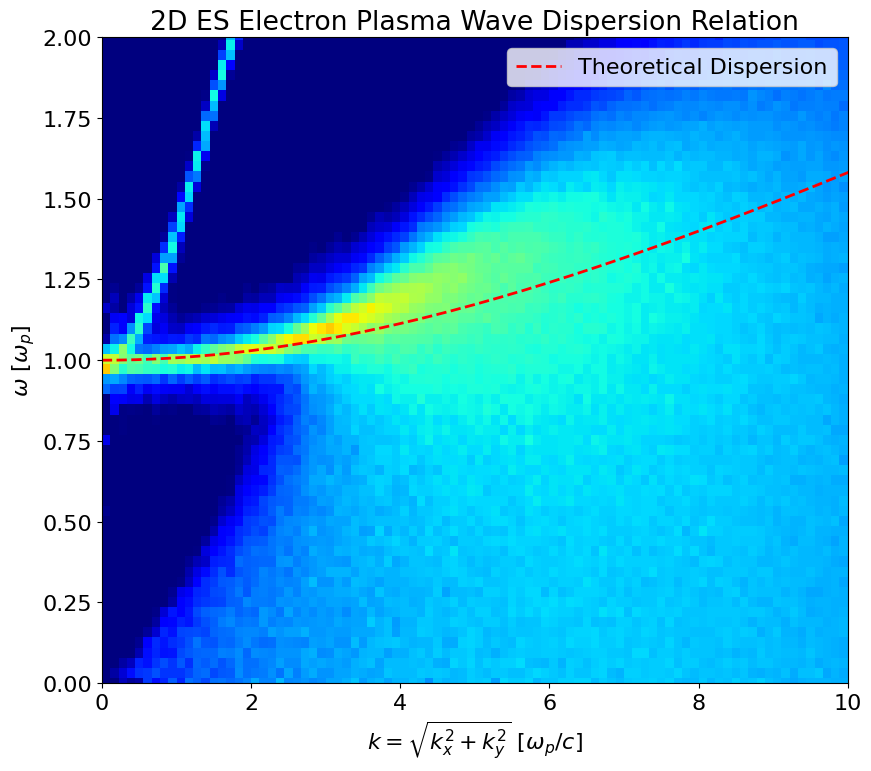

In [35]:
w = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt)) * 2 * np.pi
kx = np.fft.fftshift(np.fft.fftfreq(nx[0], d=dx[0])) * 2 * np.pi
ky = np.fft.fftshift(np.fft.fftfreq(nx[1], d=dx[1])) * 2 * np.pi

print("Maximum wave vector in x >", kx[-1])
print("Wave vector resolution in x >", kx[1] - kx[0])
print("Maximum frequency      >", w[-1])
print("Frequency resolution   >", w[1] - w[0])

Ex_fft = np.fft.fftn(Ex, axes=(0, 1, 2))
Ex_fft = np.fft.fftshift(Ex_fft, axes=(0, 1, 2))

# Create a 2D grid of kx and ky
KX, KY = np.meshgrid(kx, ky, indexing='ij')
k_abs = np.sqrt(KX**2 + KY**2)

# Set up radial bins:
nbins = 200
kmin, kmax = k_abs.min(), k_abs.max()
k_bins = np.linspace(kmin, kmax, nbins + 1)

dispersion = np.zeros((len(w), nbins))

# Loop over each frequency slice (omega) and bin the spatial Fourier amplitude radially
for iw, freq in enumerate(w):
    
    amp_2d = np.abs(Ex_fft[iw, :, :])
    bin_sum, _ = np.histogram(k_abs.flatten(), bins=k_bins, weights=amp_2d.flatten())
    bin_count, _ = np.histogram(k_abs.flatten(), bins=k_bins)
    
    # Avoid division by zero (bins with no entries)
    bin_avg = np.divide(bin_sum, bin_count, where=(bin_count > 0))
    
    dispersion[iw, :] = bin_avg

dispersion = dispersion / np.max(dispersion)

plt.figure(figsize=(9, 8))
plt.title("2D ES Electron Plasma Wave Dispersion Relation")

plt.imshow(dispersion,
           aspect='auto',
           extent=[k_bins[0], k_bins[-1], w[0], w[-1]],
           cmap='jet',
           norm=mpl.colors.LogNorm(1e-2),
           origin='lower')

plt.xlabel(r"$k = \sqrt{k_x^2+k_y^2}$ [$\omega_p/c$]")
plt.ylabel(r"$\omega$ [$\omega_p$]")

theoretical_omega = np.sqrt(1.0 + (1.5 * k_bins**2 * vth**2) / (omega_p**2))
plt.plot(k_bins, theoretical_omega, 'r--', lw=2, label="Theoretical Dispersion")
plt.xlim(0, 10)
plt.ylim(0, 2)
plt.legend()
plt.tight_layout()
plt.show()
